TO DO
1. Train Arun (vs) Non-Arun 
    - 25 min & (6.25)(4)
    - Two folders - Arun, Non-Arun
    - Collect audio between clips
2. Same for all other classifiers
3. Collect test files - 15 sec
4. Predict on all models
5. If op of all => Non => Unauthorized
   Else op of atleast 1 => not Non => Predict that as user

In [57]:
# constant paths - 
arun_25 = "D:/archive/Sound Recordings/arun_jfa.wav"
sunamdha_25 = "D:/archive/Sound Recordings/Sunamdha_pncc.wav"
abhishek_25 = "D:/archive/Sound Recordings/Abhishek_PLP.wav"
anirban_25 = "D:/archive/Sound Recordings/Anirban_ivector.wav"
shivam_25 = "D:/archive/Sound Recordings/shivam_java.wav"

arun_5 = "D:/archive/Sound Recordings/aruntestarticle.wav"
sunamdha_5 = "D:/archive/Sound Recordings/sunamdhatestarticle.wav"
abhishek_5 = "D:/archive/Sound Recordings/abhishektestarticle.wav"
anirban_5 = "D:/archive/Sound Recordings/anirbantestarticle.wav"
shivam_5 = "D:/archive/Sound Recordings/shivam_gmm.wav"

# variables - 
main_folder = "ShivamVsNonShivam"
target_user = "Shivam"
non_target_user = "NonShivam"

# Arun Vs NonArun Classifier

In [3]:
# code to create folders - 
# desired folder structure - 
    # ArunVsNonArun
        # Arun
            # 25min audio clip in 1 second clips of 48k sample rate
        # NonArun
            # 6.25min audio clip in 1 second clips of Sunamdha audio in 48k sample rate
            # 6.25min audio clip in 1 second clips of Abhishek audio in 48k sample rate
            # 6.25min audio clip in 1 second clips of Anirban audio in 48k sample rate
            # 6.25min audio clip in 1 second clips of Shivam audio in 48k sample rate

In [58]:
import os
import librosa
import soundfile as sf

# Define the path to the input audio file
input_audio_path = shivam_25

# Define the directory to store the output clips
output_directory = "TrainData/" + main_folder + "/" + target_user
os.makedirs(output_directory, exist_ok=True)

# Load the audio file
audio_data, sr = librosa.load(input_audio_path, sr=48000)

# Calculate the total number of clips (1 second each)
clip_length = sr  # 1 second
total_clips = len(audio_data) // clip_length

# Extract and store each clip
for i in range(total_clips):
    clip_start = i * clip_length
    clip_end = clip_start + clip_length
    clip = audio_data[clip_start:clip_end]
    
    # Define the output file path
    output_file_path = os.path.join(output_directory, f"clip_{i}.wav")
    
    # Save the clip
    sf.write(output_file_path, clip, sr, subtype='PCM_16')  # Using soundfile for writing the audio file

In [6]:
# check sr of random clip - 
import wave
def get_sampling_rate(filename):
    with wave.open(filename, 'rb') as wf:
        sr = wf.getframerate()
    return sr
if __name__ == "__main__":
    filename = "TrainData/ArunVsNonArun/Arun/clip_7.wav"  # Replace with your audio file path
    sr = get_sampling_rate(filename)
    print("Sampling rate:", sr)

Sampling rate: 48000


In [59]:
# 6.25 min per user into NonArun

import os
import numpy as np
import librosa
import soundfile as sf

# Define the paths to the input audio files
input_audio_paths = [arun_25, sunamdha_25, abhishek_25, anirban_25]

# Define the directory to store the output clips
output_directory = "TrainData/" + main_folder + "/" + non_target_user
os.makedirs(output_directory, exist_ok=True)

# Initialize an empty list to store the concatenated audio data
concatenated_audio_data = []

# Iterate over each input audio file
for audio_path in input_audio_paths:
    # Load the audio file
    audio_data, sr = librosa.load(audio_path, sr=48000)
    
    # Calculate the length of the 6.25 minute clip
    clip_length = sr * 60 * 6.25  # 6.25 minutes in samples
    
    # Calculate the start and end indices for the 6.25 minute clip (from the middle)
    start_index = int((len(audio_data) - clip_length) // 2)
    end_index = start_index + int(clip_length)
    
    # Extract the 6.5 minute clip and append it to the concatenated audio data
    concatenated_audio_data.extend(audio_data[start_index:end_index])

# Convert the concatenated audio data to a numpy array
concatenated_audio_data = np.array(concatenated_audio_data)

# Calculate the total number of 1-second clips in the concatenated audio
total_clips = len(concatenated_audio_data) // sr

# Extract and store each clip
for i in range(total_clips):
    clip_start = i * sr
    clip_end = clip_start + sr
    one_second_clip = concatenated_audio_data[clip_start:clip_end]
    
    # Define the output file path
    output_file_path = os.path.join(output_directory, f"clip_{i}.wav")
    
    # Save the one-second clip
    sf.write(output_file_path, one_second_clip, sr, subtype='PCM_16')  # Using soundfile for writing the audio file

In [60]:
# train a Arun vs NonArun Classifier
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import librosa.display

# Set the parent directory for speaker folders
parent_dir = "TrainData/" + main_folder

# List of speaker folders
speaker_folders = [
    target_user,
    non_target_user
]

def extract_features(parent_dir, speaker_folders):
    features = []
    labels = []

    for i, speaker_folder in enumerate(speaker_folders):
        speaker_folder_path = os.path.join(parent_dir, speaker_folder)

        for filename in os.listdir(speaker_folder_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(speaker_folder_path, filename)
                audio, sr = librosa.load(file_path, sr=48000, duration=1)
                mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=90)
                
                # Normalize MFCC features
                mfccs = StandardScaler().fit_transform(mfccs)
                
                features.append(mfccs.T)
                labels.append(i)

    return np.array(features), np.array(labels)

# Extract features and labels
X, y = extract_features(parent_dir, speaker_folders)

In [61]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

# Encode labels with explicit classes
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
label_encoder.classes_ = np.array(speaker_folders)

# Split the data into training, validation, and test sets
#X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the shapes of training and validation data
print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_test.shape)

Training Data Shape: (2184, 94, 90)
Validation Data Shape: (937, 94, 90)


Epoch 1/20
35/35 [==============================] - 9s 183ms/step - loss: 0.5484 - accuracy: 0.8741 - val_loss: 0.6353 - val_accuracy: 0.8485
Epoch 2/20
35/35 [==============================] - 6s 162ms/step - loss: 0.3832 - accuracy: 0.9487 - val_loss: 0.2671 - val_accuracy: 0.9744
Epoch 3/20
35/35 [==============================] - 5s 158ms/step - loss: 0.2216 - accuracy: 0.9858 - val_loss: 0.2386 - val_accuracy: 0.9797
Epoch 4/20
35/35 [==============================] - 6s 159ms/step - loss: 0.3162 - accuracy: 0.9579 - val_loss: 0.2554 - val_accuracy: 0.9594
Epoch 5/20
35/35 [==============================] - 5s 154ms/step - loss: 0.1810 - accuracy: 0.9849 - val_loss: 0.1609 - val_accuracy: 0.9829
Epoch 6/20
35/35 [==============================] - 5s 154ms/step - loss: 0.1211 - accuracy: 0.9977 - val_loss: 0.1098 - val_accuracy: 0.9979
Epoch 7/20
35/35 [==============================] - 5s 154ms/step - loss: 0.1134 - accuracy: 0.9940 - val_loss: 0.0924 - val_accuracy: 1.0000
Epoch 

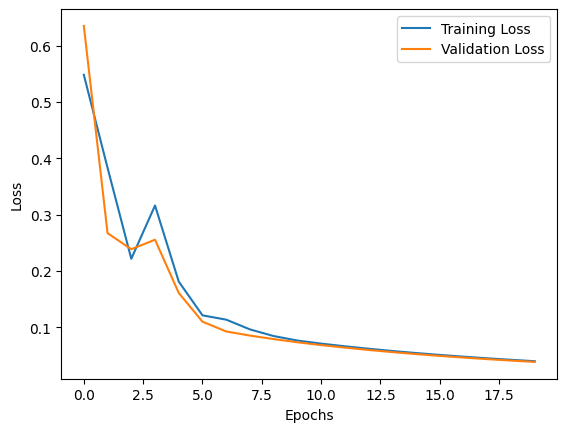

['models/ShivamVsNonShivam.joblib']

In [62]:
from tensorflow.keras.regularizers import l2
import joblib
# Define the RNN model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    #tf.keras.layers.Dropout(0.2),  # Adding dropout for regularization
    tf.keras.layers.LSTM(128),
    #tf.keras.layers.LSTM(128),
   # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Adding L2 regularization
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Adding L2 regularization
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Adding L2 regularization
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Adding L2 regularization
    tf.keras.layers.Dense(len(speaker_folders), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64, callbacks=[early_stopping])

# Check if EarlyStopping triggered
if early_stopping.stopped_epoch > 0:
    print("Early stopping triggered at epoch", early_stopping.stopped_epoch + 1)
else:
    print("Training completed without early stopping")

# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the trained model using TensorFlow's built-in saving mechanism
# model.save("models/ArunVsNonArun.h5")
# # Load the saved model
# loaded_model = tf.keras.models.load_model("trained_model.h5")

# Save the loaded model using joblib
joblib.dump(model, "models/" + main_folder + ".joblib")
# Now you can load the model using joblib
# model = joblib.load("trained_model.joblib")

30/30 [==============================] - 1s 34ms/step
Test Evaluation Accuracy: 1.0
Weighted F1 Score: 1.0


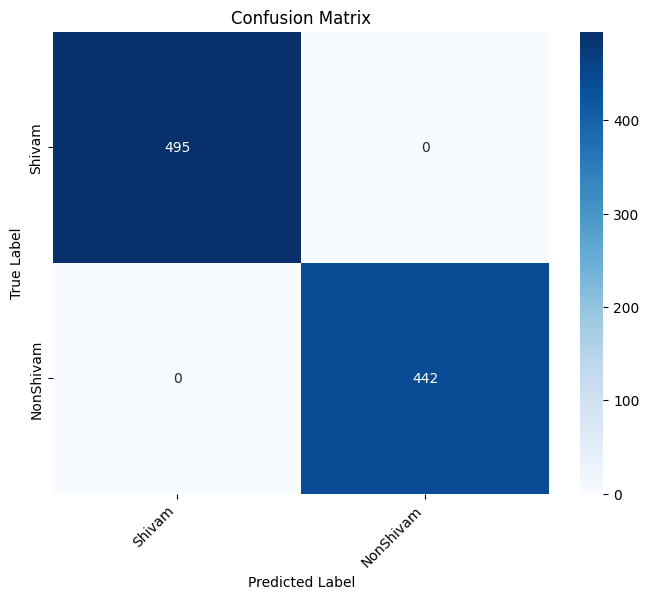

In [63]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

# Evaluate the model on the test set
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=speaker_folders)

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test_decoded, y_pred_decoded, labels=speaker_folders, average='weighted')
print(f"Weighted F1 Score: {f1}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=speaker_folders, yticklabels=speaker_folders)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [64]:
# create the Article Testing Folders - ArunTest
import os
import librosa
import soundfile as sf

# Define the path to the input audio file
input_audio_path = shivam_5

# Define the directory to store the output clips
output_directory = "TestData/" + main_folder + "/" + target_user
os.makedirs(output_directory, exist_ok=True)

# Load the audio file
audio_data, sr = librosa.load(input_audio_path, sr=48000)

# Calculate the total number of clips (1 second each)
clip_length = sr  # 1 second
total_clips = len(audio_data) // clip_length

# Extract and store each clip
for i in range(total_clips):
    clip_start = i * clip_length
    clip_end = clip_start + clip_length
    clip = audio_data[clip_start:clip_end]
    
    # Define the output file path
    output_file_path = os.path.join(output_directory, f"clip_{i}.wav")
    
    # Save the clip
    sf.write(output_file_path, clip, sr, subtype='PCM_16')  # Using soundfile for writing the audio file

In [65]:
# create the Article Testing Folders - NonArunTest
import os
import librosa
import soundfile as sf

# Define the paths to the input audio files
input_audio_paths = [arun_5, sunamdha_5, anirban_5, abhishek_5]

# Define the directory to store the output clips
output_directory = "TestData/" + main_folder + "/" + non_target_user
os.makedirs(output_directory, exist_ok=True)

# Process each input audio file
for input_audio_path in input_audio_paths:
    # Load the audio file
    audio_data, sr = librosa.load(input_audio_path, sr=48000)

    # Calculate the total number of clips (1 second each)
    clip_length = sr  # 1 second
    total_clips = len(audio_data) // clip_length

    # Extract and store each clip
    for i in range(total_clips):
        clip_start = i * clip_length
        clip_end = clip_start + clip_length
        clip = audio_data[clip_start:clip_end]

        # Define the output file path
        output_file_path = os.path.join(output_directory, f"{os.path.basename(input_audio_path)}_clip_{i}.wav")

        # Save the clip
        sf.write(output_file_path, clip, sr, subtype='PCM_16')  # Using soundfile for writing the audio file

In [66]:
# testing model with ArunArticle files
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Set the parent directory for speaker folders
parent_dir = "TestData/" + main_folder

# List of speaker folders
speaker_folders = [
    target_user,
    non_target_user
]

def extract_features(parent_dir, speaker_folders):
    features = []
    labels = []

    for i, speaker_folder in enumerate(speaker_folders):
        speaker_folder_path = os.path.join(parent_dir, speaker_folder)

        for filename in os.listdir(speaker_folder_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(speaker_folder_path, filename)
                audio, sr = librosa.load(file_path, sr=48000, duration=1)
                mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=90)
                
                # Normalize MFCC features
                mfccs = StandardScaler().fit_transform(mfccs)
                
                features.append(mfccs.T)
                labels.append(i)

    return np.array(features), np.array(labels)

# Extract features and labels
X, y = extract_features(parent_dir, speaker_folders)

52/52 [==============================] - 2s 35ms/step
Test Evaluation Accuracy: 0.9877526025719534
Weighted F1 Score: 0.9878153078622717


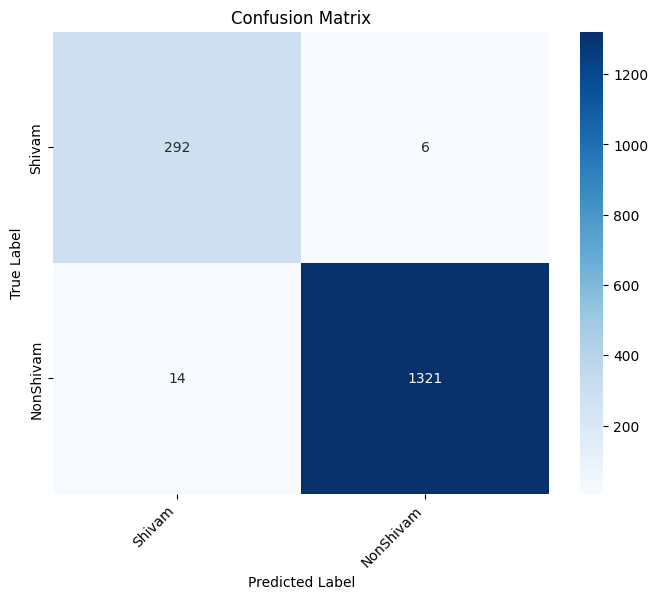

In [67]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

# Evaluate the model on the test set
y_pred_probabilities = model.predict(X)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode labels back to original format
y_test_decoded = label_encoder.inverse_transform(y)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=speaker_folders)

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test_decoded, y_pred_decoded, labels=speaker_folders, average='weighted')
print(f"Weighted F1 Score: {f1}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=speaker_folders, yticklabels=speaker_folders)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

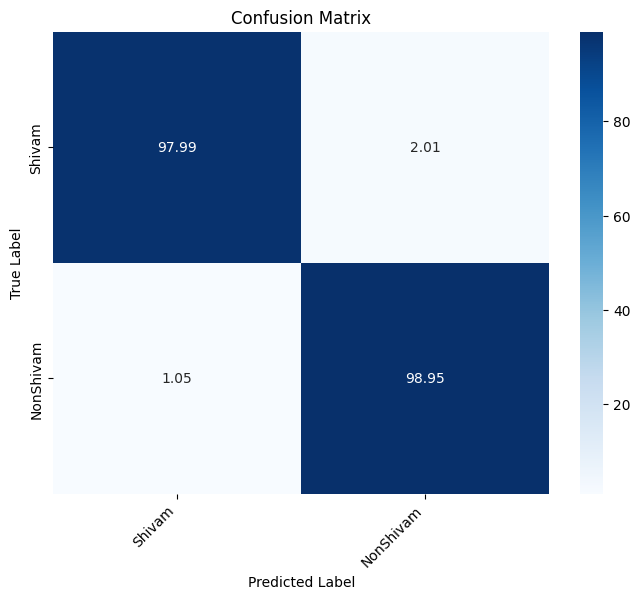

In [68]:
# Convert confusion matrix to percentages
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=speaker_folders, yticklabels=speaker_folders)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()